# Принятие решений в бизнесе

Для крупного интернет-магазина аналитиком вместе с отделом маркетинга подготовлен список гипотез для увеличения выручки.

**Наши задачи:**  
- приоритизировать гипотезы, 
- запустить A/B-тест,
- принять решение по результатам теста. 

**Описание данных**

Данные для первой части:

*Файл /datasets/hypothesis.csv.* 

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части:

*Файл /datasets/orders.csv.*

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

*Файл /datasets/visitors.csv.*
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

**План работы**

*Часть 1. Приоритизация гипотез.*

- Применим фреймворки ICE и RICE для приоритизации гипотез. 
- Посмотрим как изменилась приоритизация гипотез, проанализируем результаты.

*Часть 2. Анализ A/B-теста*

- Построим графики кумулятивной выручки, кумулятивного среднего чека и кумулятивного среднего количества заказов на посетителя по группам. 
- Посмотрим на графики относительного изменения кумулятивного среднего чека группы B к группе A и относительного изменения кумулятивного среднего количества заказов на посетителя, сделаем выводы и предположения.
- Построим точечный график количества заказов по пользователям и точечный график стоимостей заказов, посчитаем 95-й и 99-й перцентили и выберем границу для определения аномальных пользователей и среза.
- Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя и в среднем чеке заказа между группами по «сырым» данным. 
- Посчитаем статистическую значимость различий по тем же показателям между группами по «очищенным» данным. 
- Сделаем выводы и предположения.
- Примем решение по результатам теста.

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [2]:
try:
    hypothesis = pd.read_csv('/datasets/hypothesis.csv')
    visitors = pd.read_csv('/datasets/visitors.csv')
    orders = pd.read_csv('/datasets/orders.csv')
except:
    hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
    visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv')
    orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv')

In [3]:
#отобразим все сожержимое строк

pd.set_option('display.max_colwidth', None)

In [4]:
#напишем функцию для первоначального анализа и ознакомимся с данными датафреймов

def info(df):
    display(df.head())
    print(df.isna().sum())
    print(df.duplicated().sum())
    print(df.info())
    print(df.describe())
    
dfs = [hypothesis, visitors, orders]

for df in dfs:
    info(df)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


Hypothesis    0
Reach         0
Impact        0
Confidence    0
Efforts       0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None
           Reach     Impact  Confidence    Efforts
count   9.000000   9.000000    9.000000   9.000000
mean    4.777778   4.777778    5.555556   4.888889
std     3.153481   3.192874    3.045944   2.803767
min     1.000000   1.000000    1.000000   1.000000
25%     3.000000   3.000000    3.000000   3.000000
50%     3.000000   3.000000    7.000000   5.000000
75%     8.000000   7.000000    8.000000   6.000000
max    10.000000  10.000000    9.000000  10.000000


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


date        0
group       0
visitors    0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None
         visitors
count   62.000000
mean   607.290323
std    114.400560
min    361.000000
25%    534.000000
50%    624.500000
75%    710.500000
max    770.000000


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64
0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None
       transactionId     visitorId       revenue
count   1.197000e+03  1.197000e+03  1.197000e+03
mean    2.155621e+09  2.165960e+09  8.348006e+03
std     1.229085e+09  1.236014e+09  3.919113e+04
min     1.062393e+06  5.114589e+06  5.000000e+01
25%     1.166776e+09  1.111826e+09  1.220000e+03
50%     2.145194e+09  2.217985e+09  2.978000e+03
75%     3.237740e+09  3.177606e+09  8.290000e+03
max     4.293856e+09  4.283872e+09 

In [5]:
#посмотрим сколько групп в АВ-тесте

visitors['group'].unique()

array(['A', 'B'], dtype=object)

Тест парный

In [6]:
#узнаем даты начала и окончания теста

print(visitors['date'].min())
print(visitors['date'].max())

2019-08-01
2019-08-31


Тест проводится в течение месяца

In [7]:
#рассмортрим количество пользователей в каждой группе

quality = orders.groupby('group').agg({'visitorId': 'nunique'})
print(quality)
print("{:.2%}".format((quality['visitorId'][1]-quality['visitorId'][0])/quality['visitorId'][1]))

       visitorId
group           
A            503
B            586
14.16%


Пользователи распределены по группам не равномерно, разница в 14%

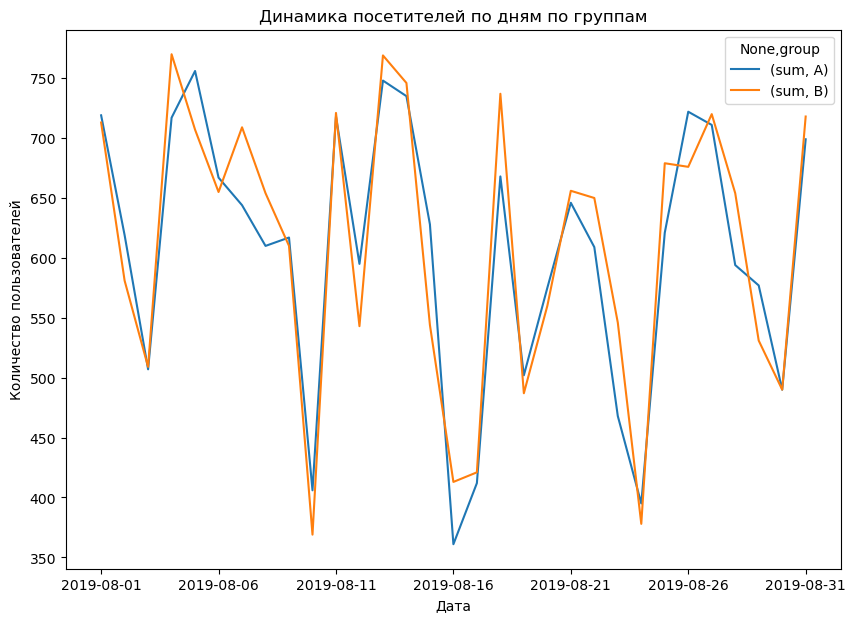

In [8]:
#посмотрим динамику посетителей по дням по группам

visitors_pivot_table = visitors.pivot_table(index='date', columns='group', values='visitors', aggfunc=['sum'])
visitors_pivot_table.plot(figsize=(10,7))
plt.title("Динамика посетителей по дням по группам")
plt.xlabel("Дата")
plt.ylabel("Количество пользователей")
plt.show()

Количество посетителей колебалось в течение месяца в диапозоне около 750 до 350 человек

In [9]:
#преобразуем тип данных о времени

visitors['date'] = pd.to_datetime(visitors['date'], format='%Y-%m-%d')
orders['date'] = pd.to_datetime(orders['date'], format='%Y-%m-%d')

#поменяем регистр столбцов

hypothesis.columns = hypothesis.columns.str.lower()

Данные готовы к анализу

### Приоритезация гипотез

#### Фреймворк ICE для приоритизации гипотез

In [10]:
hypothesis['ICE'] = round((hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts'], 2)
hypothesis.sort_values(by=['ICE'], ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00


По ICE приоритет у гипотез:
1) Запустить акцию, дающую скидку на товар в день рождения, 

2) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,

3) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок,

4) Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию	

#### Фреймворк RICE для приоритизации гипотез

In [11]:
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence'])/hypothesis['efforts'] 
hypothesis.sort_values(by=['RICE'], ascending=False)

,hypothesis,reach,impact,confidence,efforts,ICE,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5,11.20,112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3,7.00,56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6,13.33,40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3,8.00,40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5,16.20,16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8,1.12,9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10,2.00,4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3,1.33,4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1,1.00,3.0


По RICE гипотезы распредились следующим образом:
1) Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок,

2) Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа,

3) Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей,

4) Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию

Таким образом, гипотеза "Запустить акцию, дающую скидку на товар в день рождения" спустилась вниз из-за ее низкого параметра охвата (всего 1), а гипотеза "Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок" вырвалась на первое место (параметр охвата 10), она повлияет на большее количество пользователей.

###  Анализ A/B-теста

In [12]:
# проверим группы на совпадения пользователей

g_a = orders[orders['group'] == 'A']['visitorId']

g_b = orders[orders['group'] == 'B']['visitorId']

orders_ab = orders.query('visitorId in @g_a and visitorId in @g_b')

print('Количество пользователей в двух группах:', orders_ab['visitorId'].nunique())

print('Всего пользователей в тесте:', orders['visitorId'].nunique())

Количество пользователей в двух группах: 58
Всего пользователей в тесте: 1031


Очистим датафрейм от пользователей, попавших в обе группы

In [13]:
dublicates = orders_ab['visitorId'].unique()
orders = orders.query('visitorId not in @dublicates')
orders['visitorId'].nunique()

973

#### График кумулятивной выручки по группам

In [14]:
# создаем массив уникальных пар значений дат и групп теста

datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 

ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'transactionId' : 'nunique', 'visitorId' : 'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 

visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия

cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head(5)

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


In [15]:
# проверим, корректно ли был создан датафрейм cummulativeData. Например, совпадают ли минимальная и максимальная даты в этом датафрейме с минимальной и максимальной датой в исходных данных

print(cumulativeData['date'].min())
print(cumulativeData['date'].max())

2019-08-01 00:00:00
2019-08-31 00:00:00


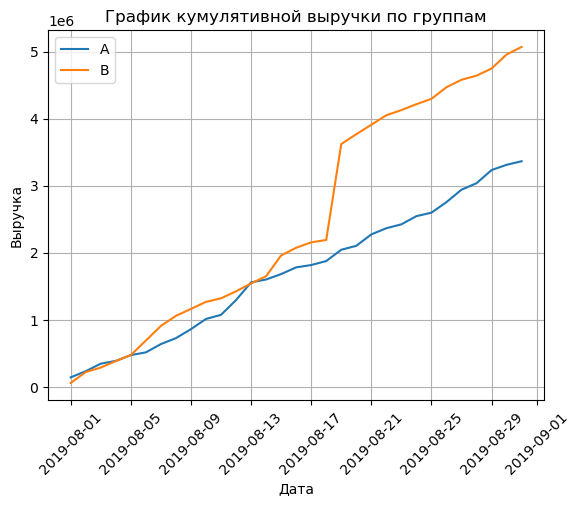

In [16]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А

cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B

cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А

plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B

plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xticks(rotation=45)
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.grid()
plt.legend()
plt.show()

В группе А выручка почти равномерно увеличивается в течение всего теста. 
А вот в группе В после 19.08.2019 выручка резко выросла. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

#### График кумулятивного среднего чека по группам

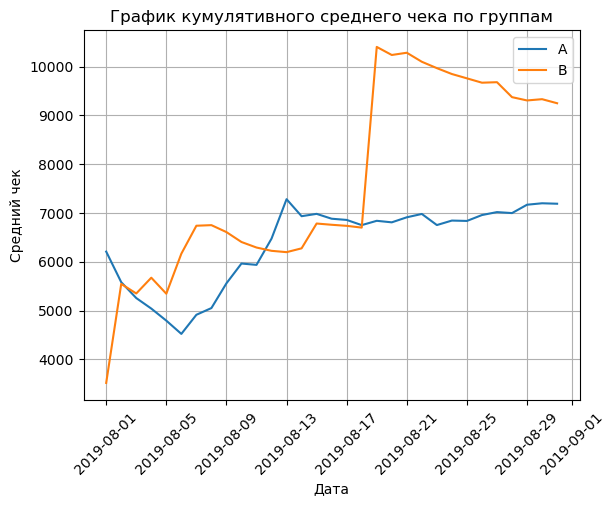

In [17]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xticks(rotation=45)
plt.title('График кумулятивного среднего чека по группам')
plt.xlabel('Дата')
plt.ylabel('Средний чек')
plt.grid()
plt.legend()
plt.show()

Средний чек становится равномерным к середине теста (после 15.08.2019) для группы A. Для группы B так же видим резкий всплеск 19.08.2019 и далее снижение чека. Возможно, в группу B в это время попали крупные заказы. Тогда ей нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

#### График относительного изменения кумулятивного среднего чека группы B к группе A

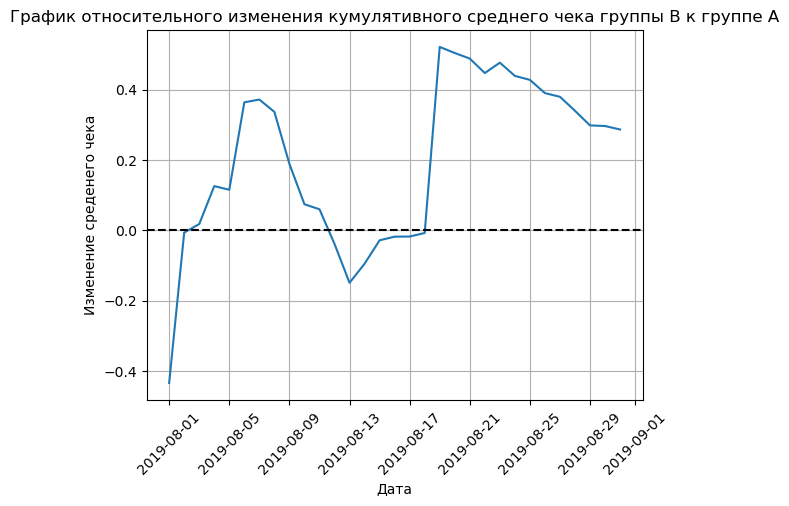

In [18]:
# собираем данные в одном датафрейме

mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков

plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X

plt.axhline(y=0, color='black', linestyle='--')

plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивного среднего чека группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение среденего чека')
plt.grid()
plt.show()

В нескольких точках график различия между сегментами резко «скачет». Есть крупные заказы и выбросы.

#### График кумулятивного среднего количества заказов на посетителя по группам

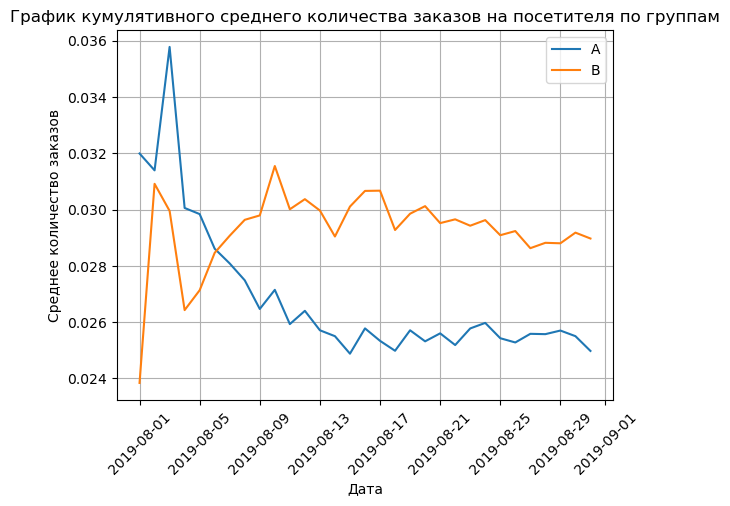

In [19]:
# считаем кумулятивное среднее количество заказов на посетителя

cumulativeData['avg_orders_visitior'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A

cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B

cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики

plt.plot(cumulativeDataA['date'], cumulativeDataA['avg_orders_visitior'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['avg_orders_visitior'], label='B')

plt.xticks(rotation=45)
plt.title('График кумулятивного среднего количества заказов на посетителя по группам')
plt.xlabel('Дата')
plt.ylabel('Среднее количество заказов')
plt.grid()
plt.legend()
plt.show()

Сначала группы колебались, но затем среднее количество заказов группы В вырвалось вперёд и зафиксировалось, а среднее количество заказов группы А просело и также зафиксировалось.

#### График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A

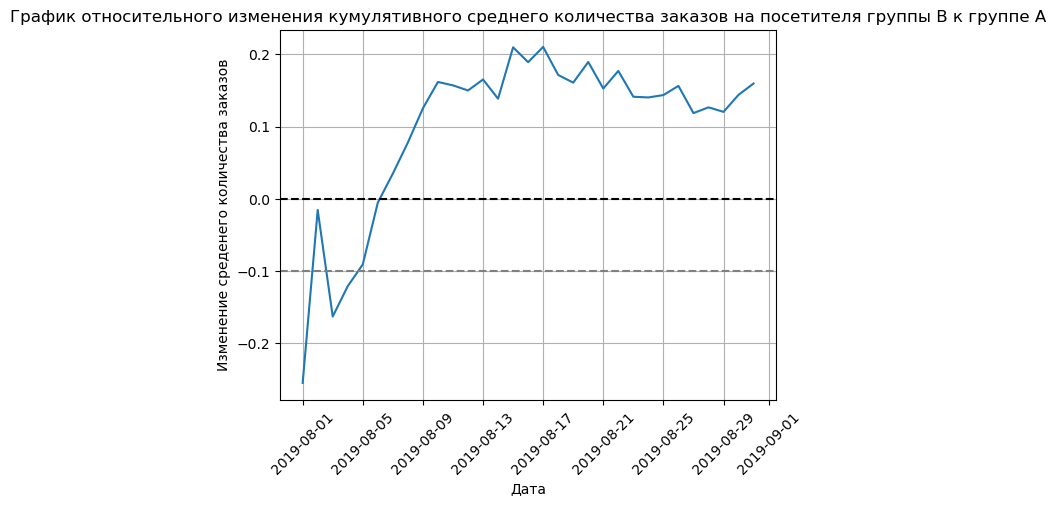

In [20]:
mergedCumulativeAvgorders = cumulativeDataA[['date','avg_orders_visitior']].merge(cumulativeDataB[['date','avg_orders_visitior']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeAvgorders['date'], mergedCumulativeAvgorders['avg_orders_visitiorB']/mergedCumulativeAvgorders['avg_orders_visitiorA']-1)

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.xticks(rotation=45)
plt.title('График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A')
plt.xlabel('Дата')
plt.ylabel('Изменение среденего количества заказов')
plt.grid()
plt.show()

В начале теста группа B значительно проигрывала группе A, затем вырвалась вперёд. Потом среднее количество заказов на пользователя падало, но теперь постепенно растёт.
В целом сейчас делать какие-либо выводы по тесту нельзя, стоит проанализировать аномалии, возможно, они изменят картину.

#### Точечный график количества заказов по пользователям

      visitorId  orders
908  3967698036       3
55    249864742       3
478  2108163459       3
687  2988190573       3
890  3908431265       3
138   611059232       3
632  2742574263       3
157   678354126       2
323  1404560065       2
452  1985475298       2


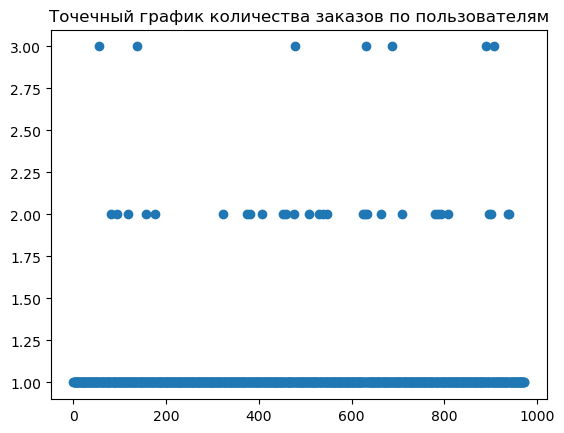

In [21]:
ordersByUsers = (
    orders.groupby('visitorId', as_index=False)
    .agg({'transactionId': 'nunique'})
)
ordersByUsers.columns = ['visitorId', 'orders']

print(ordersByUsers.sort_values(by='orders', ascending=False).head(10))

# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0, len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.show()

Большинство покупателей заказывали только один раз. Покупателей совершивших 2 заказа значительно меньше, а 3 - единицы.

In [22]:
np.percentile(ordersByUsers['orders'], [95, 99])

array([1., 2.])

Не более 5% пользователей оформляли больше чем 1 заказ. И лишь 1% оформляли более 2 заказов. 
Разумно выбрать 2 заказа на одного пользователя за верхнюю границу числа заказов, и отсеять аномальных пользователей по ней.

#### Точечный график стоимостей заказов

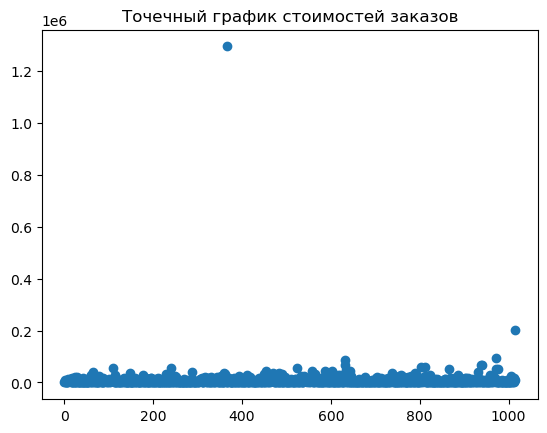

In [23]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue']) 
plt.title('Точечный график стоимостей заказов')
plt.show()

Есть выброс в районе 1,2 млн. Заказ на такую сумму в интернет-магазине выглядит аномально.

In [24]:
np.percentile(orders['revenue'], [95, 99])

array([26785., 53904.])

Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Выберем верхнюю границу для стоимости заказа в 53 904 руб.

#### Статистическая значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «сырым» данным

Посчитаем статистическую значимость различий в среднем числе заказов на пользователя между группами по «сырым» данным — без удаления аномальных пользователей.
Сформулируем гипотезы. 

Нулевая: различий в среднем количестве заказов между группами нет. 

Альтернативная: различия в среднем между группами есть. 

Критический уровень статистической значимости - 0.05

Метод, который будем применять для A/B-тестирования критерий Манна-Уитни, потому как он даёт возможность делать вывод о различии или его отсутствии для любого заданного уровня значимости и подходит когда работа с самими значениями невозможна из-за выбросов, сильно сдвигающих параметрические результаты.

Начнём с подготовки данных.

In [25]:
import scipy.stats as stats

visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5))

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              23           142779              17   
1 2019-08-02              19            91602              23   
2 2019-08-03              24           112473              14   
3 2019-08-04              11            41176              14   
4 2019-08-05              22            86383              21   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0            59758                  23               142779   
1           162043                  42               234381   
2            67049                  66               346854   
3            96890                  77               388030   
4            89908                  99               474413   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  17                59758               719   
1                  40               221801               619   
2                  54               28

In [26]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("p_value: {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Различие в среднем числе заказов на пользователя между группами: {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))


p_value: 0.011
Различие в среднем числе заказов на пользователя между группами: 0.160


Вывод: По «сырым» данным различия в среднем числе заказов группы A и B есть. 
Первое число — p-value = 0.011 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Относительный выигрыш группы B равен 16%.

Теперь проверим статистическую значимость различий в среднем чеке между сегментами. Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

In [27]:
print('p_value: {0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Различие в среднем чеке между группами {0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

p_value: 0.829
Различие в среднем чеке между группами 0.287


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. При этом средний чек группы B значительно выше среднего чека группы A (почти на 29%) 

#### Статистическая значимость различий в среднем числе заказов на пользователя и среднем чеке между группами по «очищенным» данным

Сделаем срезы пользователей с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 53 904 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers. 
Узнаем, сколько всего аномальных пользователей

In [28]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 53904]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print(abnormalUsers.shape[0])
print("{:.2%}".format(abnormalUsers.shape[0]/orders['visitorId'].nunique()))

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
Name: visitorId, dtype: int64
16
1.64%


Аномальных пользователей не так много, всего 16, это около 1,6 % от общего количества пользователей участвующих в тесте, но они могут повлиять на его результаты.

Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста.

In [29]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

In [30]:
#применим статистический критерий Манна-Уитни к полученным выборкам

print('p_value: {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Различие в среднем числе заказов на пользователя между группами: {0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

p_value: 0.007
Различие в среднем числе заказов на пользователя между группами: 0.189


Результаты по среднему количеству заказов не изменились. 

In [31]:
#посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным

print(
    'p_value: {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Различие в среднем чеке между группами: {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

p_value: 0.788
Различие в среднем чеке между группами: -0.032


Общие выводы по результатам теста не изменились - нет причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, но разница между сегментами сократилась с примерно 29% до 3%.

### Выводы и принятие решения

Имеющиеся факты:

Есть статистически значимое различие по среднему количеству заказов между группами и по «сырым», и по данным после фильтрации аномалий;

Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

График различия среднего количества заказов между группами сообщает, что результаты группы B лучше группы A, имеют тенденцию к росту;

График различия среднего чека колеблется: он-то и позволил нам найти аномалии. Сделать из этого графика определённые выводы нельзя.

Таким образом, принимаем решение остановить тест, признать его успешным, зафиксировать победу группы B по среднему количеству заказов и перейти к проверке следующей гипотезы.